# makemore: part 5
Makemore: Part 5

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
# Load the dataset 
words = open('names.txt', 'r').read().splitlines()


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8

def build_dataset(words):
    
    X, Y = [], []
    for w in words:
        # padded context of zero tokens with block size expected
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(137)
random.shuffle(words)
n1 = int (0.8 * len(words))
n2 = int (0.9 * len(words))
 
Xtr, Ytr = build_dataset(words[:n1])      #80%
Xdev, Ydev = build_dataset(words[n1:n2])  #10%
Xte, Yte = build_dataset(words[n2:])      #10%


torch.Size([182355, 8]) torch.Size([182355])
torch.Size([22935, 8]) torch.Size([22935])
torch.Size([22856, 8]) torch.Size([22856])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> d
.......d ---> o
......do ---> n
.....don ---> a
....dona ---> v
...donav ---> i
..donavi ---> n
.donavin ---> .
........ ---> l
.......l ---> e
......le ---> i
.....lei ---> g
....leig ---> h
...leigh ---> a
..leigha ---> n
.leighan ---> a
leighana ---> .
........ ---> y
.......y ---> u
......yu ---> n


In [11]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming initialization for normalized variance
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-6, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      dims = [d for d in range(0, x.dim() - 1)]
      xmean = x.mean(tuple(dims), keepdim=True) # batch mean
      xvar = x.var(tuple(dims), keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# ---------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# ---------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
        
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
        
  def parameters(self):
    return [self.weight]

# ---------------
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# ---------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

    

In [12]:
torch.manual_seed(42)


In [13]:
n_embd = 10
n_hidden = 68


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),    
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 #last layer is reduced so that we make it less confident at the beginning
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [15]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
lossv = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01 if i > 2*max_steps/3 else 0.1

  for p in parameters:
    p.data += -lr * p.grad
    
  with torch.no_grad():
    ix = torch.randint(0, Xdev.shape[0], (batch_size,))
    Xv, Yv = Xdev[ix], Ydev[ix]
    vlogits = model(Xv)
    l = F.cross_entropy(vlogits, Yv)
    lossv.append(l.log10().item())

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: loss(test): {loss.item():.4f} :loss(val): {l.item():.4f} : lr:{lr:.3f}' )
    
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


      0/ 200000: loss(test): 3.2811 :loss(val): 3.2802 : lr:0.100
  10000/ 200000: loss(test): 1.8232 :loss(val): 1.7104 : lr:0.100
  20000/ 200000: loss(test): 1.7830 :loss(val): 2.2907 : lr:0.100
  30000/ 200000: loss(test): 1.9976 :loss(val): 1.7091 : lr:0.100
  40000/ 200000: loss(test): 2.1792 :loss(val): 1.8902 : lr:0.100
  50000/ 200000: loss(test): 1.9218 :loss(val): 2.2074 : lr:0.100
  60000/ 200000: loss(test): 2.0094 :loss(val): 2.2494 : lr:0.100
  70000/ 200000: loss(test): 2.3297 :loss(val): 1.9106 : lr:0.100
  80000/ 200000: loss(test): 1.4524 :loss(val): 2.6398 : lr:0.100
  90000/ 200000: loss(test): 1.8336 :loss(val): 1.9042 : lr:0.100
 100000/ 200000: loss(test): 1.9044 :loss(val): 2.1936 : lr:0.100
 110000/ 200000: loss(test): 2.3829 :loss(val): 1.9015 : lr:0.100
 120000/ 200000: loss(test): 2.5941 :loss(val): 2.0807 : lr:0.100
 130000/ 200000: loss(test): 1.6773 :loss(val): 2.1844 : lr:0.100
 140000/ 200000: loss(test): 1.9517 :loss(val): 1.8555 : lr:0.010
 150000/ 2

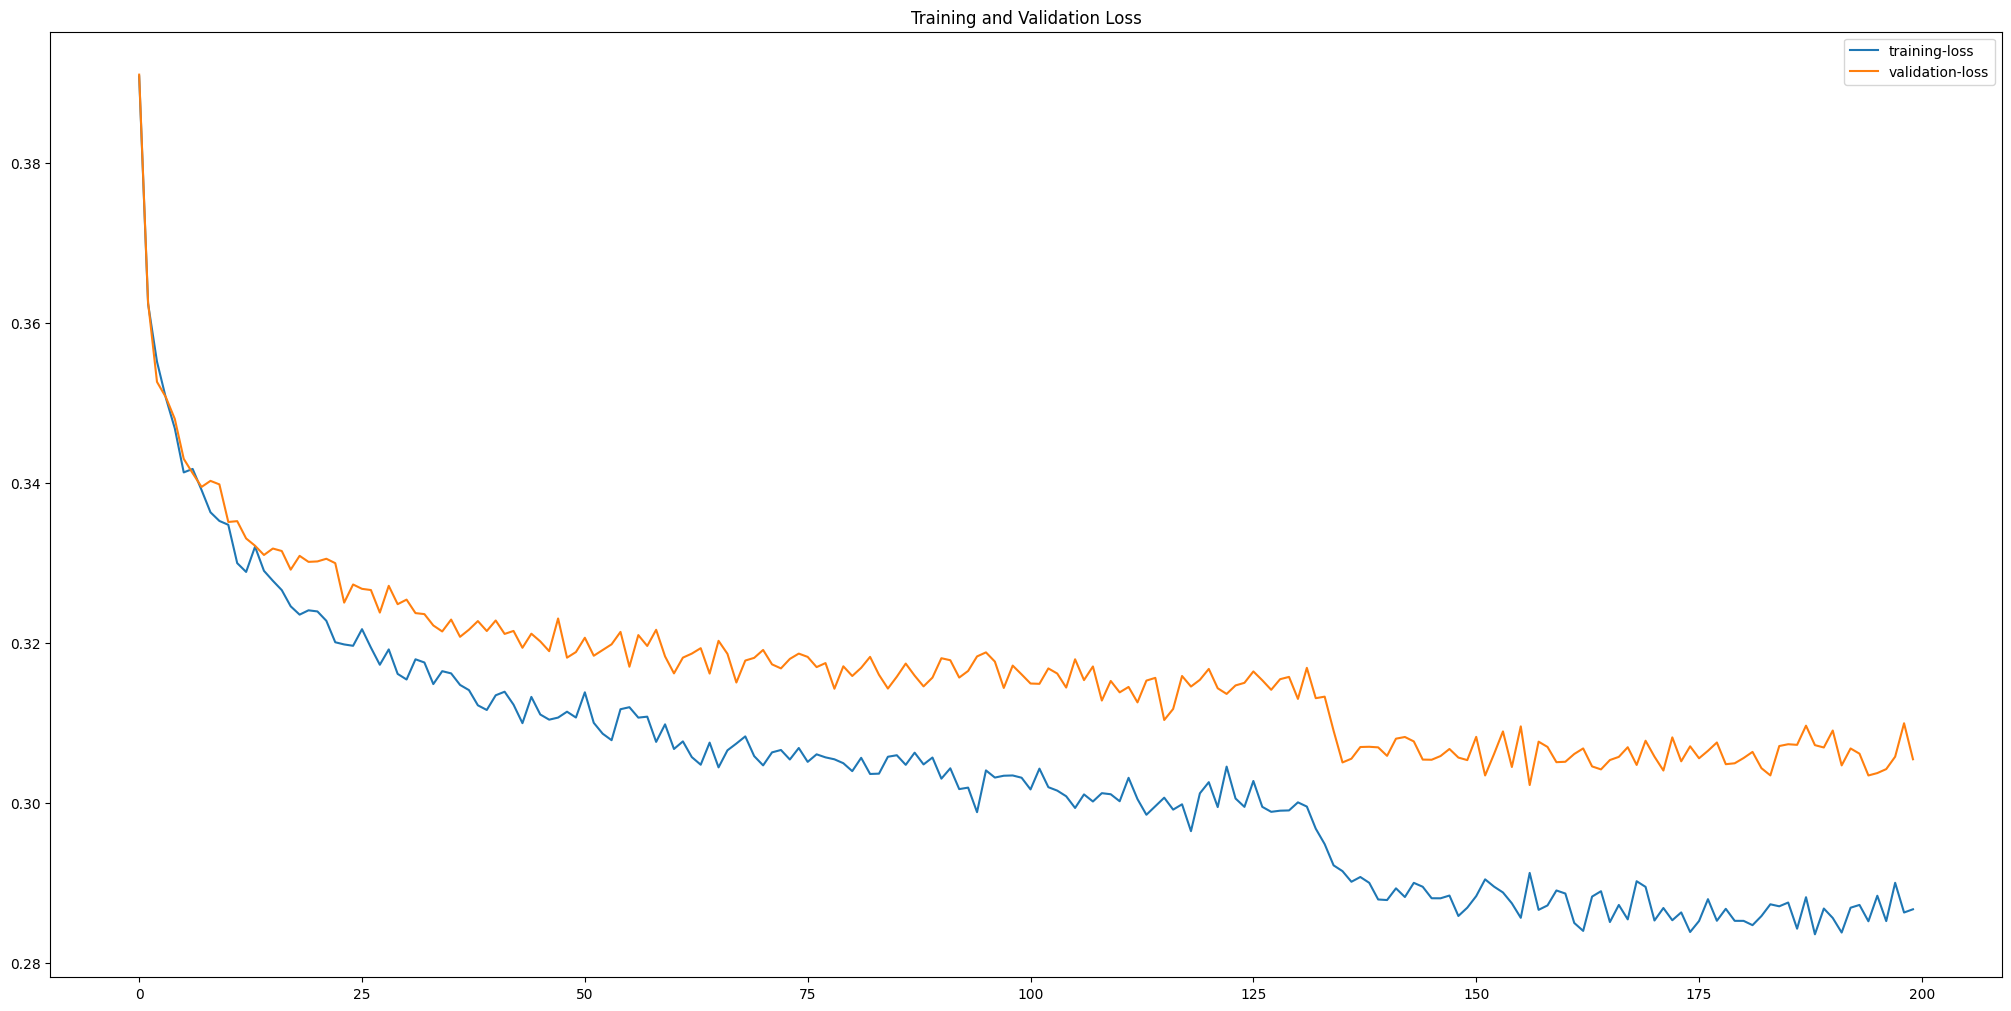

In [37]:
lvi = torch.tensor(lossi).view(-1,1000).mean(1)
lvp = torch.tensor(lossv).view(-1,1000).mean(1)


fig, ax = plt.subplots(figsize=(20, 10), layout='constrained')
ax.plot(lvi, label='training-loss')  
ax.plot(lvp, label='validation-loss')  
ax.set_title("Training and Validation Loss") 
ax.legend();  # Add a legend.

In [38]:
for layer in model.layers:
    layer.training = False
    


In [39]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # take 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 13,  1,  8],
        [ 0,  0,  0,  2, 18,  9,  5, 14],
        [ 0,  0,  0,  0, 13, 15, 19,  8],
        [ 0,  0,  0,  0,  0, 15, 13,  1]])

In [40]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))
    

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [41]:
model.layers[-7].running_mean.shape

torch.Size([1, 1, 68])

In [42]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.9137517213821411
val 2.009603500366211


In [43]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net

      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word



rosiyah.
irdck.
eweslyanna.
sarionna.
zzoison.
wariell.
harlis.
anael.
rutania.
demison.
buniv.
kennela.
nohan.
corrin.
maxon.
ylaanuh.
dijuke.
maijae.
torajine.
gwesyn.
